## Collaborative Sorters

Can robots collaborate better than humans?
Can robots learn to collaborate? How can they adapt to the presence of each other? Can they re-adapt when a situation changes? How to impact robots' decision making by global control? Exploration vs exploitation. How to unite (generalize) the obtained models from individual sensors? How diverse are the models obtained by every robot?

Simulate a cognitive production with learning robots using a very trivial model:
* discrete time steps
* the band moves with a constant (precified) speed
* trivial collision avoidance

Parameters:
* number of robots and their positions
* number of colors (?) -- right now not used, but colors could be used to specify priorities.
* band speed / speeds of robots
* scores for sorting each product type
* length of the shoulder of a robotic arm (currently unlimited)

Expected emergence behavior:
* will each robot have a favourite color?
* will robots favor closer objects?
* will robots have disjoint operation area or not? Does the speed of the band matter? (yes)

In [2]:
# This code is required for collision detection. 
# Source: https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect/17198094
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersection((A,B),(C,D)):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [3]:
__author__ = 'osaukh'
from collections import deque
import random
import tkinter as tk
import time
import math

W = 30
XY = (12, 20)
colors = ("red", "green", "blue", "yellow")

stat = list()


class RoboticArm(object):
    def __init__(self, canvas, *args, **kwargs):
        self.canvas = canvas
        self.id = canvas.create_oval(*args, **kwargs)
        x1, y1, x2, y2 = self.canvas.bbox(self.id)
        
        # plus and minus points the arm gets for its decisions
        self.score_plus = 0
        self.score_minus = 0
        self.label_plus = canvas.create_text((x1+x2)/2,y1+(y2-y1)/4, text=self.score_plus, fill="black")
        self.label_minus = canvas.create_text((x1+x2)/2,y2-(y2-y1)/4, text=self.score_minus, fill="red")
            
        # robotic arm geometry is an array of connected points
        self.armgeo = [ (x1+x2)/2, (y1+y2)/2, (x1+x2)/2, (y1+y2)/2, (x1+x2)/2, (y1+y2)/2 ]
        self.arm = self.canvas.create_line(self.armgeo, fill="magenta", capstyle=tk.ROUND, width=20)
        self.pselect = 0
        
    def getarmlegs(self):
        lx = (self.armgeo[0:2], self.armgeo[2:4])
        ly = (self.armgeo[2:4], self.armgeo[4:6])
        return (lx, ly)
        
    def getscore(self):
        return self.score
    
    def reset_position(self):
        self.pselect = 0
        self.armgeo[2] = self.armgeo[0]
        self.armgeo[5] = self.armgeo[1]
        self.armgeo[4] = self.armgeo[2]
        
    def move(self, products):
        # try block, because the product may have been taken by another robot,
        # this will generate an exception
        try:
            # decide for the next random object
            if (self.pselect == 0):
                self.pselect = list(products)[random.randint(0,len(products))]
                self.pselect.select()
        
            # get object coordinates
            x1, y1, x2, y2 = self.canvas.bbox(self.pselect.getid())
            # move the arm left if you haven't reached the object yet
            if (self.armgeo[2] > abs((x1+x2)/2)): 
                self.armgeo[2] = self.armgeo[2] - W/6
            else:
                # move the arm up
                if (self.armgeo[5] > abs((y1+y2)/2)):
                    self.armgeo[5] = self.armgeo[5] - W/6
                # move the arm down
                elif (self.armgeo[5] < abs((y1+y2)/2)):
                    self.armgeo[5] = self.armgeo[5] + W/6
                else:
                    # you reached the object
                    self.score_plus += 1
                    self.canvas.itemconfig(self.label_plus,text=self.score_plus)
                    self.pselect.remove()
                    products.remove(self.pselect)
                    self.reset_position()
        except:
            # the product has been taken by another robot => reset
            self.score_minus += 1
            self.canvas.itemconfig(self.label_minus,text=self.score_minus)
            self.reset_position()
            
        self.armgeo[4] = self.armgeo[2]
        self.canvas.coords(self.arm, tuple(self.armgeo))
        return products
    
    def handlecollision(self):
        # reset the arm
        self.score_minus += 1
        self.canvas.itemconfig(self.label_minus,text=self.score_minus)
        self.pselect.unselect()
        self.reset_position()
        self.canvas.coords(self.arm, tuple(self.armgeo))

    

class Product(object):
    def __init__(self, canvas, *args, **kwargs):
        self.canvas = canvas
        self.id = canvas.create_oval(*args, **kwargs)

    def move(self):
        self.canvas.move(self.id, 0, W)

    def getid(self):
        return self.id
    
    def select(self):
        self.canvas.itemconfig(self.id,outline='black', width=3)
        
    def unselect(self):
        self.canvas.itemconfig(self.id,outline='black', width=1)

    def remove(self):
        self.canvas.delete(self.id)
        
        
        
class App(object):
    def __init__(self, master, **kwargs):
        self.master = master
        self.canvas = tk.Canvas(self.master, width=XY[0]*W + 4*W, height=XY[1]*W)
        self.canvas.pack()
        
        self.products = deque()
        self.n_products_per_line = 2
        self.init_board()
        
        self.robots = deque()
        self.n_robots = 10
        self.add_robots()
        
        self.canvas.pack()
        self.master.after(0, self.animation)
        self.timeindex = 0
        
    def init_board(self):        
        for i in range(XY[0]):
            for j in range(XY[1]):
                self.canvas.create_rectangle(i*W, j*W, (i+1)*W, (j+1)*W, fill="white", width=1)
        for j in reversed(range(XY[1])):
            self.add_new_products(line=j)
            
        self.label_prod = self.canvas.create_text(XY[0]*W+W/2,W/2, text="0", fill="blue")
        self.label_time = self.canvas.create_text(XY[0]*W+3*W+W/2,W/2, text="0", fill="blue")
        
    def add_robots(self):
        rnew = range(int(XY[1] / 2))
        random.shuffle(rnew)
        for i in range(self.n_robots):
            self.robots.append(RoboticArm(self.canvas, XY[0]*W+W, rnew[i]*W*2, XY[0]*W+3*W, rnew[i]*W*2+2*W, outline='white', fill="orange"))        

    def add_new_products(self, line):
        pnew = range(XY[0])
        random.shuffle(pnew)
        for i in range(self.n_products_per_line):
            self.products.append(Product(self.canvas, pnew[i]*W, line*W, pnew[i]*W+W, line*W+W, 
                                         outline='white', fill=colors[random.randint(0,len(colors)-1)]) )

    def collisiondetection(self):
        for robot1 in self.robots:
            for robot2 in self.robots:
                if robot1 != robot2:
                    (lx1, ly1) = robot1.getarmlegs()
                    (lx2, ly2) = robot2.getarmlegs()
                    if intersection(ly1, lx2) or intersection(ly1, ly2) or intersection(ly2, lx1) or intersection(lx2, lx1):
                        # symmetry breaking: decide randomly
                        if (random.randint(0,2) % 2 == 0):
                            robot1.handlecollision()
                        else:
                            robot2.handlecollision()
            
    def animation(self):
        self.timeindex += 1
        self.canvas.itemconfig(self.label_prod,text=len(self.products))
        self.canvas.itemconfig(self.label_time,text=self.timeindex)
        stat.append(len(self.products))
        
        if (self.timeindex % 20 == 0):
            # move all products one line down
            for product in list(self.products):
                product.move()
                x1, y1, x2, y2 = self.canvas.bbox(product.getid())
                if y1 >= XY[1]*W:
                     self.products.remove(product)
            # add new products
            self.add_new_products(line=0)
        
        # move robotic arms
        for robot in self.robots:
            self.products = robot.move(self.products)
                 
        # detect collisions
        self.collisiondetection()
        
        # animate
        self.master.after(10, self.animation)

        
root = tk.Tk()
app = App(root)
root.mainloop()

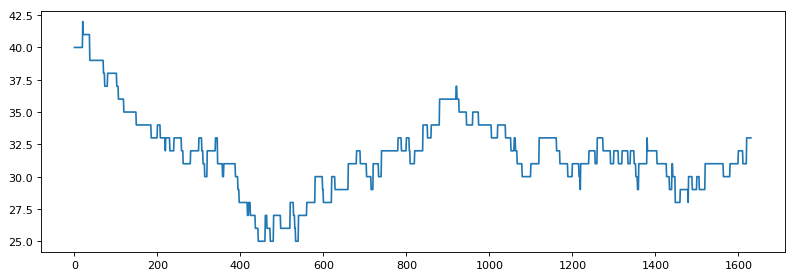

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(stat)
plt.show()